# Overview of this jupyter notebook

1. Loading the data
2. Hyperparameter optimization for RandomForest Model
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from skmultilearn.problem_transform import BinaryRelevance
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')
import pickle
import json
import random

In [2]:
import os
import importlib
from library import etl_data as etl            # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.etl_data' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\etl_data.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [3]:
!python -V

Python 3.10.6


# 1. Loading the data

In [4]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [5]:
feature_train = pd.read_pickle("feature_label/mlc_feature_train_tsfresh_2.4.pkl")
feature_train.shape

(1550, 789)

In [6]:
feature_test = pd.read_pickle("feature_label/mlc_feature_test_tsfresh_2.4.pkl")
feature_test.shape

(750, 789)

In [7]:
label_train = pd.read_pickle("feature_label/mlc_label_train_tsfresh_v2.4.pkl")
label_train.shape

(1550, 8)

In [8]:
label_test = pd.read_pickle("feature_label/mlc_label_test_tsfresh_v2.4.pkl")
label_test.shape

(750, 8)

In [9]:
relevance_table = pd.read_pickle("feature_label/mlc_relevance_table_tsfresh_v2.4.pkl")
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
torque__friedrich_coefficients__coeff_3__m_3__r_30,torque__friedrich_coefficients__coeff_3__m_3__...,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__max_langevin_fixed_point__m_3__r_30,torque__max_langevin_fixed_point__m_3__r_30,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__number_crossing_m__m_-1,torque__number_crossing_m__m_-1,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False


In [10]:
relevance_table = relevance_table[relevance_table.relevant==True]
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"torque__fft_coefficient__attr_""imag""__coeff_92","torque__fft_coefficient__attr_""imag""__coeff_92",real,9.478897e-01,False,1.716470e-01,False,9.849157e-01,False,1.072699e-04,True,8.559883e-01,False,5.015247e-01,False,1.822312e-01,False,4.250886e-01,False,4.911643e-01,False,1.170838e-02,False,1.711853e-01,False,8.991722e-01,False,0.025441,False,7.237413e-01,False,0.292634,False,1,True
"torque__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)",torque__cwt_coefficients__coeff_12__w_2__width...,real,9.544628e-01,False,2.995364e-12,True,1.424985e-01,False,3.158056e-02,False,4.182010e-03,False,5.572269e-01,False,1.291619e-01,False,2.636988e-01,False,2.499537e-07,True,2.074936e-01,False,6.579449e-01,False,8.661737e-02,False,0.083162,False,6.838159e-01,False,0.142855,False,2,True
"torque__fft_coefficient__attr_""real""__coeff_91","torque__fft_coefficient__attr_""real""__coeff_91",real,9.748111e-01,False,1.528592e-01,False,9.135638e-01,False,2.650780e-05,True,9.138683e-01,False,6.113325e-01,False,5.596143e-01,False,2.779372e-01,False,4.141510e-01,False,1.277503e-02,False,1.527884e-01,False,7.170111e-01,False,0.003934,False,5.555035e-01,False,0.163287,False,1,True


In [11]:
relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

615

In [12]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((1550, 615), (750, 615))

In [13]:
lab_train = label_train.values
lab_test = label_test.values
lab_train.shape, lab_test.shape

((1550, 8), (750, 8))

In [14]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train, lab_train, random_state=9)
x_test, y_test = shuffle(feat_test, lab_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

# 2. Hyperparameter optimization for RandomForest Model

In [18]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier

In [27]:
parameters = {'classifier__n_estimators':[50, 100, 200], 'classifier__criterion':['gini', 'entropy'],
              'classifier__min_samples_leaf': [1,4,8], 'classifier__min_samples_split': [2,4,8],
              'classifier__max_depth':[20,80,200], 'classifier__max_features':['sqrt', 'log2'],
              'classifier__min_impurity_decrease':[0.0, 0.0001, 0.001]}

search = GridSearchCV(BinaryRelevance(RandomForestClassifier()), parameters, cv=5, scoring='accuracy', verbose=10)
search.fit(x_train, y_train)
print(search.best_score_, search.best_params_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV 1/5; 1/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 1/5; 1/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.845 total time=   3.7s
[CV 2/5; 1/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 2/5; 1/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__

[CV 2/5; 4/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.829 total time=   3.8s
[CV 3/5; 4/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 3/5; 4/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.845 total time=   3.8s
[CV 4/5; 4/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier

[CV 4/5; 7/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.832 total time=   3.8s
[CV 5/5; 7/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 5/5; 7/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.842 total time=   3.8s
[CV 1/5; 8/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier

[CV 1/5; 11/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.835 total time=   6.6s
[CV 2/5; 11/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 11/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.829 total time=   6.7s
[CV 3/5; 11/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, cla

[CV 2/5; 14/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.816 total time=   6.7s
[CV 3/5; 14/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/5; 14/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.829 total time=   6.9s
[CV 4/5; 14/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, cla

[CV 3/5; 17/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.858 total time=   6.8s
[CV 4/5; 17/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 4/5; 17/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.848 total time=   6.6s
[CV 5/5; 17/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, cla

[CV 4/5; 20/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.823 total time=   6.2s
[CV 5/5; 20/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 5/5; 20/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.816 total time=   6.3s
[CV 1/5; 21/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, cla

[CV 5/5; 23/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.832 total time=   6.3s
[CV 1/5; 24/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 24/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.803 total time=  12.2s
[CV 2/5; 24/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, cla

[CV 1/5; 27/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.806 total time=  12.5s
[CV 2/5; 27/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 2/5; 27/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.823 total time=  12.7s
[CV 3/5; 27/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, cla

[CV 2/5; 30/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.823 total time=  15.4s
[CV 3/5; 30/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 3/5; 30/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.858 total time=  15.6s
[CV 4/5; 30/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_

[CV 3/5; 33/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.852 total time=  15.5s
[CV 4/5; 33/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 4/5; 33/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.858 total time=  15.2s
[CV 5/5; 33/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_

[CV 4/5; 36/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.845 total time=  15.1s
[CV 5/5; 36/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 36/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.835 total time=  15.5s
[CV 1/5; 37/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_

[CV 5/5; 39/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.826 total time=  13.8s
[CV 1/5; 40/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 1/5; 40/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.823 total time=   3.5s
[CV 2/5; 40/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_sp

[CV 1/5; 43/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.829 total time=   3.4s
[CV 2/5; 43/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 2/5; 43/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.839 total time=   3.4s
[CV 3/5; 43/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_spl

[CV 2/5; 46/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.806 total time=   3.2s
[CV 3/5; 46/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 3/5; 46/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.829 total time=   3.4s
[CV 4/5; 46/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_spl

[CV 3/5; 49/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.823 total time=   3.2s
[CV 4/5; 49/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 4/5; 49/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.823 total time=   3.2s
[CV 5/5; 49/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_spl

[CV 4/5; 52/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.806 total time=   3.1s
[CV 5/5; 52/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 5/5; 52/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.823 total time=   3.1s
[CV 1/5; 53/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_spl

[CV 5/5; 55/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.829 total time=   3.4s
[CV 1/5; 56/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 56/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.826 total time=   6.8s
[CV 2/5; 56/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split

[CV 1/5; 59/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.832 total time=   6.6s
[CV 2/5; 59/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 2/5; 59/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.826 total time=   6.7s
[CV 3/5; 59/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_spli

[CV 2/5; 62/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.832 total time=   6.9s
[CV 3/5; 62/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 62/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.852 total time=   6.9s
[CV 4/5; 62/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_spli

[CV 3/5; 65/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.842 total time=   6.1s
[CV 4/5; 65/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 4/5; 65/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.832 total time=   6.1s
[CV 5/5; 65/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_spli

[CV 4/5; 68/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.835 total time=   6.0s
[CV 5/5; 68/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 5/5; 68/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.819 total time=   6.1s
[CV 1/5; 69/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_spli

[CV 5/5; 71/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.826 total time=   6.0s
[CV 1/5; 72/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 1/5; 72/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.823 total time=  11.8s
[CV 2/5; 72/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_spli

[CV 1/5; 75/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.800 total time=  11.3s
[CV 2/5; 75/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 2/5; 75/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.823 total time=  11.5s
[CV 3/5; 75/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_spli

[CV 2/5; 78/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.813 total time=  11.3s
[CV 3/5; 78/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 3/5; 78/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.826 total time=  11.3s
[CV 4/5; 78/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_spli

[CV 3/5; 81/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.826 total time=  11.3s
[CV 4/5; 81/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 4/5; 81/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.813 total time=  11.0s
[CV 5/5; 81/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_spli

[CV 4/5; 84/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.839 total time=   7.1s
[CV 5/5; 84/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 5/5; 84/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.835 total time=   7.1s
[CV 1/5; 85/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, cla

[CV 5/5; 87/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.826 total time=   7.1s
[CV 1/5; 88/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 1/5; 88/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.829 total time=   1.8s
[CV 2/5; 88/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, class

[CV 1/5; 91/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.810 total time=   1.7s
[CV 2/5; 91/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 2/5; 91/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.813 total time=   1.7s
[CV 3/5; 91/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classi

[CV 2/5; 94/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.806 total time=   1.8s
[CV 3/5; 94/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 3/5; 94/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.829 total time=   1.7s
[CV 4/5; 94/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classi

[CV 3/5; 97/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.823 total time=   1.7s
[CV 4/5; 97/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 4/5; 97/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.832 total time=   1.7s
[CV 5/5; 97/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classi

[CV 4/5; 100/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.813 total time=   1.6s
[CV 5/5; 100/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 5/5; 100/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.803 total time=   1.6s
[CV 1/5; 101/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, cl

[CV 5/5; 103/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.787 total time=   1.6s
[CV 1/5; 104/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 1/5; 104/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.777 total time=   3.2s
[CV 2/5; 104/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, 

[CV 1/5; 107/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.790 total time=   3.2s
[CV 2/5; 107/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 2/5; 107/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.810 total time=   3.1s
[CV 3/5; 107/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8,

[CV 2/5; 110/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.829 total time=   3.6s
[CV 3/5; 110/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 3/5; 110/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.842 total time=   3.5s
[CV 4/5; 110/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samp

[CV 3/5; 113/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.829 total time=   3.6s
[CV 4/5; 113/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 4/5; 113/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.845 total time=   3.5s
[CV 5/5; 113/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samp

[CV 4/5; 116/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.842 total time=   3.6s
[CV 5/5; 116/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 5/5; 116/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.839 total time=   3.6s
[CV 1/5; 117/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samp

[CV 5/5; 119/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.816 total time=   3.3s
[CV 1/5; 120/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 1/5; 120/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.819 total time=   6.7s
[CV 2/5; 120/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samp

[CV 1/5; 123/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.829 total time=   6.6s
[CV 2/5; 123/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 2/5; 123/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.826 total time=   6.6s
[CV 3/5; 123/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samp

[CV 2/5; 126/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.810 total time=   6.7s
[CV 3/5; 126/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 3/5; 126/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.829 total time=   6.7s
[CV 4/5; 126/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samp

[CV 3/5; 129/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.797 total time=   6.4s
[CV 4/5; 129/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 4/5; 129/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.803 total time=   6.4s
[CV 5/5; 129/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samp

[CV 4/5; 132/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.803 total time=   6.5s
[CV 5/5; 132/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 5/5; 132/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.800 total time=   6.6s
[CV 1/5; 133/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samp

[CV 5/5; 135/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.813 total time=   6.5s
[CV 1/5; 136/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 1/5; 136/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.803 total time=   1.7s
[CV 2/5; 136/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_s

[CV 1/5; 139/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.819 total time=   1.7s
[CV 2/5; 139/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 2/5; 139/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.810 total time=   1.7s
[CV 3/5; 139/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_spl

[CV 2/5; 142/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.800 total time=   1.7s
[CV 3/5; 142/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 3/5; 142/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.823 total time=   1.7s
[CV 4/5; 142/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_spl

[CV 3/5; 145/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.813 total time=   1.6s
[CV 4/5; 145/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 4/5; 145/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.803 total time=   1.6s
[CV 5/5; 145/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_spl

[CV 4/5; 148/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.819 total time=   1.6s
[CV 5/5; 148/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 5/5; 148/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.800 total time=   1.6s
[CV 1/5; 149/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_spl

[CV 5/5; 151/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.794 total time=   1.6s
[CV 1/5; 152/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 1/5; 152/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.797 total time=   3.1s
[CV 2/5; 152/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_s

[CV 1/5; 155/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.771 total time=   3.0s
[CV 2/5; 155/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 155/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.784 total time=   3.1s
[CV 3/5; 155/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_

[CV 2/5; 158/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.797 total time=   3.0s
[CV 3/5; 158/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/5; 158/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.781 total time=   3.0s
[CV 4/5; 158/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_

[CV 3/5; 161/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.810 total time=   3.0s
[CV 4/5; 161/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 4/5; 161/972] END classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.797 total time=   3.0s
[CV 5/5; 161/972] START classifier__criterion=gini, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_

[CV 4/5; 164/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.848 total time=   7.8s
[CV 5/5; 164/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 5/5; 164/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.832 total time=   7.8s
[CV 1/5; 165/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2,

[CV 5/5; 167/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.835 total time=   7.8s
[CV 1/5; 168/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 168/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.848 total time=  15.3s
[CV 2/5; 168/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4,

[CV 1/5; 171/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.845 total time=  15.3s
[CV 2/5; 171/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 2/5; 171/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.835 total time=  14.9s
[CV 3/5; 171/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8,

[CV 2/5; 174/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.823 total time=  13.5s
[CV 3/5; 174/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 3/5; 174/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.855 total time=  13.7s
[CV 4/5; 174/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2,

[CV 3/5; 177/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.845 total time=  13.8s
[CV 4/5; 177/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 4/5; 177/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.829 total time=  13.3s
[CV 5/5; 177/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4,

[CV 4/5; 180/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.842 total time=  13.2s
[CV 5/5; 180/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 180/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.835 total time=  13.6s
[CV 1/5; 181/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2,

[CV 5/5; 183/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.819 total time=  12.4s
[CV 1/5; 184/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 1/5; 184/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.829 total time=   3.0s
[CV 2/5; 184/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, c

[CV 1/5; 187/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.806 total time=   3.1s
[CV 2/5; 187/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 2/5; 187/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.826 total time=   3.1s
[CV 3/5; 187/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, cl

[CV 2/5; 190/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.835 total time=   3.8s
[CV 3/5; 190/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 3/5; 190/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.835 total time=   3.8s
[CV 4/5; 190/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples

[CV 3/5; 193/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.852 total time=   3.9s
[CV 4/5; 193/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 4/5; 193/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.835 total time=   3.7s
[CV 5/5; 193/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples

[CV 4/5; 196/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.845 total time=   3.8s
[CV 5/5; 196/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 5/5; 196/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.832 total time=   3.8s
[CV 1/5; 197/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples

[CV 5/5; 199/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.826 total time=   3.4s
[CV 1/5; 200/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 200/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.826 total time=   6.6s
[CV 2/5; 200/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_sampl

[CV 1/5; 203/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.835 total time=   6.7s
[CV 2/5; 203/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 2/5; 203/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.832 total time=   6.8s
[CV 3/5; 203/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samp

[CV 2/5; 206/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.829 total time=   6.6s
[CV 3/5; 206/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 206/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.855 total time=   6.8s
[CV 4/5; 206/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samp

[CV 3/5; 209/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.823 total time=   6.1s
[CV 4/5; 209/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 4/5; 209/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.832 total time=   6.1s
[CV 5/5; 209/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samp

[CV 4/5; 212/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.819 total time=   6.2s
[CV 5/5; 212/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 5/5; 212/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.823 total time=   6.1s
[CV 1/5; 213/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samp

[CV 5/5; 215/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.823 total time=   6.1s
[CV 1/5; 216/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 1/5; 216/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.832 total time=  12.4s
[CV 2/5; 216/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samp

[CV 1/5; 219/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.832 total time=  13.3s
[CV 2/5; 219/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 2/5; 219/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.823 total time=  13.4s
[CV 3/5; 219/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_

[CV 2/5; 222/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.826 total time=  13.5s
[CV 3/5; 222/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 3/5; 222/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.855 total time=  13.6s
[CV 4/5; 222/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_

[CV 3/5; 225/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.835 total time=  13.4s
[CV 4/5; 225/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 4/5; 225/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.832 total time=  13.5s
[CV 5/5; 225/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_

[CV 4/5; 228/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.823 total time=  12.1s
[CV 5/5; 228/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 5/5; 228/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.826 total time=  12.1s
[CV 1/5; 229/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_

[CV 5/5; 231/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.823 total time=  12.1s
[CV 1/5; 232/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 1/5; 232/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.806 total time=   3.1s
[CV 2/5; 232/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_sp

[CV 1/5; 235/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.771 total time=   2.8s
[CV 2/5; 235/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 2/5; 235/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.803 total time=   2.9s
[CV 3/5; 235/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_spl

[CV 2/5; 238/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.819 total time=   2.9s
[CV 3/5; 238/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 3/5; 238/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.813 total time=   3.0s
[CV 4/5; 238/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_spl

[CV 3/5; 241/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.823 total time=   3.0s
[CV 4/5; 241/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 4/5; 241/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.813 total time=   2.9s
[CV 5/5; 241/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_spl

[CV 4/5; 244/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.835 total time=   1.9s
[CV 5/5; 244/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 5/5; 244/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.826 total time=   1.9s
[CV 1/5; 245/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, cl

[CV 5/5; 247/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.842 total time=   1.9s
[CV 1/5; 248/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 1/5; 248/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.861 total time=   3.7s
[CV 2/5; 248/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, 

[CV 1/5; 251/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.829 total time=   3.7s
[CV 2/5; 251/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 2/5; 251/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.826 total time=   3.6s
[CV 3/5; 251/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8,

[CV 2/5; 254/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.816 total time=   3.4s
[CV 3/5; 254/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 3/5; 254/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.816 total time=   3.4s
[CV 4/5; 254/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2,

[CV 3/5; 257/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.832 total time=   3.4s
[CV 4/5; 257/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 4/5; 257/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.823 total time=   3.5s
[CV 5/5; 257/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4,

[CV 4/5; 260/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.832 total time=   3.4s
[CV 5/5; 260/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 5/5; 260/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.816 total time=   3.5s
[CV 1/5; 261/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8,

[CV 5/5; 263/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.810 total time=   3.3s
[CV 1/5; 264/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 1/5; 264/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.794 total time=   6.5s
[CV 2/5; 264/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2,

[CV 1/5; 267/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.794 total time=   6.5s
[CV 2/5; 267/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 2/5; 267/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.797 total time=   6.5s
[CV 3/5; 267/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4,

[CV 2/5; 270/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.806 total time=   6.6s
[CV 3/5; 270/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 3/5; 270/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.787 total time=   6.6s
[CV 4/5; 270/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8,

[CV 3/5; 273/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.858 total time=   7.5s
[CV 4/5; 273/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 4/5; 273/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.852 total time=   7.2s
[CV 5/5; 273/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samp

[CV 4/5; 276/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.848 total time=   7.3s
[CV 5/5; 276/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 5/5; 276/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.832 total time=   7.3s
[CV 1/5; 277/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samp

[CV 5/5; 279/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.826 total time=   7.3s
[CV 1/5; 280/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 1/5; 280/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.806 total time=   1.7s
[CV 2/5; 280/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_sample

[CV 1/5; 283/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.806 total time=   1.7s
[CV 2/5; 283/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 2/5; 283/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.813 total time=   1.7s
[CV 3/5; 283/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples

[CV 2/5; 286/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.810 total time=   1.7s
[CV 3/5; 286/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 3/5; 286/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.816 total time=   1.7s
[CV 4/5; 286/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples

[CV 3/5; 289/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.790 total time=   1.7s
[CV 4/5; 289/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 4/5; 289/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.800 total time=   1.6s
[CV 5/5; 289/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples

[CV 4/5; 292/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.810 total time=   1.6s
[CV 5/5; 292/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 5/5; 292/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.784 total time=   1.7s
[CV 1/5; 293/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples

[CV 5/5; 295/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.803 total time=   1.6s
[CV 1/5; 296/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 1/5; 296/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.787 total time=   3.2s
[CV 2/5; 296/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_sampl

[CV 1/5; 299/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.826 total time=   3.4s
[CV 2/5; 299/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 299/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.810 total time=   3.3s
[CV 3/5; 299/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_

[CV 2/5; 302/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.803 total time=   3.6s
[CV 3/5; 302/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/5; 302/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.823 total time=   3.9s
[CV 4/5; 302/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_

[CV 3/5; 305/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.826 total time=   4.4s
[CV 4/5; 305/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 4/5; 305/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.813 total time=   4.9s
[CV 5/5; 305/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_

[CV 4/5; 308/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.813 total time=   3.1s
[CV 5/5; 308/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 5/5; 308/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.810 total time=   3.1s
[CV 1/5; 309/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_

[CV 5/5; 311/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.813 total time=   3.1s
[CV 1/5; 312/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 312/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.797 total time=   6.1s
[CV 2/5; 312/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_

[CV 1/5; 315/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.806 total time=   6.1s
[CV 2/5; 315/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 2/5; 315/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.800 total time=   6.2s
[CV 3/5; 315/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_

[CV 2/5; 318/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.794 total time=   5.9s
[CV 3/5; 318/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 3/5; 318/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.790 total time=   5.9s
[CV 4/5; 318/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_

[CV 3/5; 321/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.797 total time=   6.0s
[CV 4/5; 321/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 4/5; 321/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.803 total time=   5.9s
[CV 5/5; 321/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_

[CV 4/5; 324/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.794 total time=   5.9s
[CV 5/5; 324/972] START classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 324/972] END classifier__criterion=gini, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.777 total time=   5.9s
[CV 1/5; 325/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_s

[CV 5/5; 327/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.839 total time=  15.1s
[CV 1/5; 328/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 1/5; 328/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.852 total time=   3.7s
[CV 2/5; 328/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=

[CV 1/5; 331/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.842 total time=   3.6s
[CV 2/5; 331/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 2/5; 331/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.826 total time=   3.7s
[CV 3/5; 331/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8

[CV 2/5; 334/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.810 total time=   3.4s
[CV 3/5; 334/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 3/5; 334/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.832 total time=   3.4s
[CV 4/5; 334/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2

[CV 3/5; 337/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.861 total time=   3.4s
[CV 4/5; 337/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 4/5; 337/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.839 total time=   3.4s
[CV 5/5; 337/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4

[CV 4/5; 340/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.842 total time=   3.4s
[CV 5/5; 340/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 5/5; 340/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.832 total time=   3.4s
[CV 1/5; 341/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8

[CV 5/5; 343/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.813 total time=   3.1s
[CV 1/5; 344/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 344/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.823 total time=   6.1s
[CV 2/5; 344/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split

[CV 1/5; 347/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.806 total time=   6.1s
[CV 2/5; 347/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 2/5; 347/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.800 total time=   6.2s
[CV 3/5; 347/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_spli

[CV 2/5; 350/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.819 total time=   6.4s
[CV 3/5; 350/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 350/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.819 total time=   6.4s
[CV 4/5; 350/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_spli

[CV 3/5; 353/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.852 total time=   7.5s
[CV 4/5; 353/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 4/5; 353/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.855 total time=   7.5s
[CV 5/5; 353/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_

[CV 4/5; 356/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.858 total time=   7.4s
[CV 5/5; 356/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 5/5; 356/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.832 total time=   7.6s
[CV 1/5; 357/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_

[CV 5/5; 359/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.839 total time=   7.5s
[CV 1/5; 360/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 1/5; 360/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.848 total time=  14.6s
[CV 2/5; 360/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_

[CV 1/5; 363/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.839 total time=  13.4s
[CV 2/5; 363/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 2/5; 363/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.829 total time=  13.3s
[CV 3/5; 363/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_

[CV 2/5; 366/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.823 total time=  13.6s
[CV 3/5; 366/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 3/5; 366/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.855 total time=  14.0s
[CV 4/5; 366/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_

[CV 3/5; 369/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.852 total time=  13.9s
[CV 4/5; 369/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 4/5; 369/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.839 total time=  13.6s
[CV 5/5; 369/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_

[CV 4/5; 372/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.813 total time=  12.6s
[CV 5/5; 372/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 5/5; 372/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.806 total time=  12.7s
[CV 1/5; 373/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_

[CV 5/5; 375/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.823 total time=  12.8s
[CV 1/5; 376/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 1/5; 376/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.816 total time=   3.1s
[CV 2/5; 376/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_sa

[CV 1/5; 379/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.832 total time=   3.5s
[CV 2/5; 379/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 2/5; 379/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.839 total time=   3.5s
[CV 3/5; 379/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples

[CV 2/5; 382/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.835 total time=   3.5s
[CV 3/5; 382/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 3/5; 382/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.852 total time=   3.6s
[CV 4/5; 382/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples

[CV 3/5; 385/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.839 total time=   3.6s
[CV 4/5; 385/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 4/5; 385/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.835 total time=   3.4s
[CV 5/5; 385/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples

[CV 4/5; 388/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.819 total time=   3.2s
[CV 5/5; 388/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 5/5; 388/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.810 total time=   3.0s
[CV 1/5; 389/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples

[CV 5/5; 391/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.826 total time=   3.2s
[CV 1/5; 392/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 1/5; 392/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.826 total time=   6.3s
[CV 2/5; 392/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_sampl

[CV 1/5; 395/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.819 total time=   6.1s
[CV 2/5; 395/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 2/5; 395/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.823 total time=   6.0s
[CV 3/5; 395/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samp

[CV 2/5; 398/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.813 total time=   5.7s
[CV 3/5; 398/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 3/5; 398/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.816 total time=   5.7s
[CV 4/5; 398/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samp

[CV 3/5; 401/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.823 total time=   5.8s
[CV 4/5; 401/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 4/5; 401/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.806 total time=   5.6s
[CV 5/5; 401/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samp

[CV 4/5; 404/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.816 total time=   5.7s
[CV 5/5; 404/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 5/5; 404/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.806 total time=   5.8s
[CV 1/5; 405/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samp

[CV 5/5; 407/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.861 total time=   3.6s
[CV 1/5; 408/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 1/5; 408/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.842 total time=   7.2s
[CV 2/5; 408/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_spli

[CV 1/5; 411/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.839 total time=   7.2s
[CV 2/5; 411/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 2/5; 411/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.832 total time=   7.2s
[CV 3/5; 411/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_spli

[CV 2/5; 414/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.823 total time=   7.2s
[CV 3/5; 414/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 3/5; 414/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.848 total time=   7.2s
[CV 4/5; 414/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_spli

[CV 3/5; 417/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.832 total time=   6.9s
[CV 4/5; 417/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 4/5; 417/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.832 total time=   6.7s
[CV 5/5; 417/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_spli

[CV 4/5; 420/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.832 total time=   6.8s
[CV 5/5; 420/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 5/5; 420/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.826 total time=   6.7s
[CV 1/5; 421/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_spli

[CV 5/5; 423/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.810 total time=   6.8s
[CV 1/5; 424/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 1/5; 424/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.765 total time=   1.6s
[CV 2/5; 424/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=

[CV 1/5; 427/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.774 total time=   1.6s
[CV 2/5; 427/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 2/5; 427/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.797 total time=   1.6s
[CV 3/5; 427/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4

[CV 2/5; 430/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.810 total time=   1.6s
[CV 3/5; 430/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 3/5; 430/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.790 total time=   1.6s
[CV 4/5; 430/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8

[CV 3/5; 433/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.848 total time=   1.9s
[CV 4/5; 433/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 4/5; 433/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.839 total time=   1.8s
[CV 5/5; 433/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_sam

[CV 4/5; 436/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.819 total time=   1.9s
[CV 5/5; 436/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 5/5; 436/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.832 total time=   1.8s
[CV 1/5; 437/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_sam

[CV 5/5; 439/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.826 total time=   1.9s
[CV 1/5; 440/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 1/5; 440/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.842 total time=   3.5s
[CV 2/5; 440/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_s

[CV 1/5; 443/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.823 total time=   3.2s
[CV 2/5; 443/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 443/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.819 total time=   3.4s
[CV 3/5; 443/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_

[CV 2/5; 446/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.819 total time=   3.4s
[CV 3/5; 446/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/5; 446/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.823 total time=   3.4s
[CV 4/5; 446/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_

[CV 3/5; 449/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.819 total time=   3.4s
[CV 4/5; 449/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 4/5; 449/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.823 total time=   3.4s
[CV 5/5; 449/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_

[CV 4/5; 452/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.806 total time=   3.2s
[CV 5/5; 452/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 5/5; 452/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.803 total time=   3.2s
[CV 1/5; 453/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_

[CV 5/5; 455/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.810 total time=   3.2s
[CV 1/5; 456/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 456/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.777 total time=   6.3s
[CV 2/5; 456/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_

[CV 1/5; 459/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.790 total time=   6.5s
[CV 2/5; 459/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 2/5; 459/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.797 total time=   6.2s
[CV 3/5; 459/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_

[CV 2/5; 462/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.823 total time=   6.6s
[CV 3/5; 462/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 3/5; 462/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.839 total time=   6.6s
[CV 4/5; 462/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samp

[CV 3/5; 465/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.819 total time=   6.6s
[CV 4/5; 465/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 4/5; 465/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.826 total time=   6.4s
[CV 5/5; 465/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samp

[CV 4/5; 468/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.832 total time=   6.6s
[CV 5/5; 468/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 468/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.826 total time=   6.5s
[CV 1/5; 469/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samp

[CV 5/5; 471/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.813 total time=   6.2s
[CV 1/5; 472/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 1/5; 472/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.797 total time=   1.6s
[CV 2/5; 472/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_sample

[CV 1/5; 475/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.787 total time=   1.6s
[CV 2/5; 475/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 2/5; 475/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.790 total time=   1.6s
[CV 3/5; 475/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples

[CV 2/5; 478/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.800 total time=   1.5s
[CV 3/5; 478/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 3/5; 478/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.797 total time=   1.5s
[CV 4/5; 478/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples

[CV 3/5; 481/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.790 total time=   1.5s
[CV 4/5; 481/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 4/5; 481/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.794 total time=   1.5s
[CV 5/5; 481/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples

[CV 4/5; 484/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.813 total time=   1.5s
[CV 5/5; 484/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 5/5; 484/972] END classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.777 total time=   1.5s
[CV 1/5; 485/972] START classifier__criterion=gini, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples

[CV 5/5; 487/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.865 total time=   4.3s
[CV 1/5; 488/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 488/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.868 total time=   8.5s
[CV 2/5; 488/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_sampl

[CV 1/5; 491/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.874 total time=   8.6s
[CV 2/5; 491/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 2/5; 491/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.845 total time=   8.5s
[CV 3/5; 491/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samp

[CV 2/5; 494/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.845 total time=   8.6s
[CV 3/5; 494/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 494/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.868 total time=   8.6s
[CV 4/5; 494/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samp

[CV 3/5; 497/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.865 total time=   8.7s
[CV 4/5; 497/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 4/5; 497/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.871 total time=   8.6s
[CV 5/5; 497/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samp

[CV 4/5; 500/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.861 total time=   8.6s
[CV 5/5; 500/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 5/5; 500/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.848 total time=   8.4s
[CV 1/5; 501/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samp

[CV 5/5; 503/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.855 total time=   8.6s
[CV 1/5; 504/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 1/5; 504/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.868 total time=  16.6s
[CV 2/5; 504/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samp

[CV 1/5; 507/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.845 total time=  16.2s
[CV 2/5; 507/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 2/5; 507/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.845 total time=  16.5s
[CV 3/5; 507/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samp

[CV 2/5; 510/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.839 total time=  16.4s
[CV 3/5; 510/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 3/5; 510/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.848 total time=  16.5s
[CV 4/5; 510/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samp

[CV 3/5; 513/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.852 total time=  16.5s
[CV 4/5; 513/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 4/5; 513/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.845 total time=  16.4s
[CV 5/5; 513/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samp

[CV 4/5; 516/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.868 total time=  17.9s
[CV 5/5; 516/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 5/5; 516/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.848 total time=  18.0s
[CV 1/5; 517/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifi

[CV 5/5; 519/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.855 total time=  17.6s
[CV 1/5; 520/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 1/5; 520/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.865 total time=   4.4s
[CV 2/5; 520/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier

[CV 1/5; 523/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.842 total time=   4.2s
[CV 2/5; 523/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 2/5; 523/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.845 total time=   4.2s
[CV 3/5; 523/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier_

[CV 2/5; 526/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.839 total time=   4.2s
[CV 3/5; 526/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 3/5; 526/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.865 total time=   4.2s
[CV 4/5; 526/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier_

[CV 3/5; 529/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.871 total time=   4.2s
[CV 4/5; 529/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 4/5; 529/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.845 total time=   4.2s
[CV 5/5; 529/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier_

[CV 4/5; 532/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.848 total time=   4.0s
[CV 5/5; 532/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 5/5; 532/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.835 total time=   4.1s
[CV 1/5; 533/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier_

[CV 5/5; 535/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.832 total time=   4.0s
[CV 1/5; 536/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 1/5; 536/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.839 total time=   7.8s
[CV 2/5; 536/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifie

[CV 1/5; 539/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.835 total time=   8.1s
[CV 2/5; 539/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 2/5; 539/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.839 total time=   8.0s
[CV 3/5; 539/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifi

[CV 2/5; 542/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.845 total time=   8.9s
[CV 3/5; 542/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 3/5; 542/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.865 total time=   9.0s
[CV 4/5; 542/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__

[CV 3/5; 545/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.874 total time=   8.8s
[CV 4/5; 545/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 4/5; 545/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.861 total time=   8.7s
[CV 5/5; 545/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__

[CV 4/5; 548/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.868 total time=   8.7s
[CV 5/5; 548/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 5/5; 548/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.852 total time=   8.7s
[CV 1/5; 549/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__

[CV 5/5; 551/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.848 total time=   8.6s
[CV 1/5; 552/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 1/5; 552/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.861 total time=  17.2s
[CV 2/5; 552/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__

[CV 1/5; 555/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.861 total time=  17.1s
[CV 2/5; 555/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 2/5; 555/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.845 total time=  17.2s
[CV 3/5; 555/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__

[CV 2/5; 558/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.855 total time=  17.2s
[CV 3/5; 558/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 3/5; 558/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.871 total time=  17.4s
[CV 4/5; 558/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__

[CV 3/5; 561/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.855 total time=  16.7s
[CV 4/5; 561/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 4/5; 561/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.845 total time=  16.2s
[CV 5/5; 561/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__

[CV 4/5; 564/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.839 total time=  16.1s
[CV 5/5; 564/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 5/5; 564/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.832 total time=  16.4s
[CV 1/5; 565/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__

[CV 5/5; 567/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.829 total time=  16.0s
[CV 1/5; 568/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 1/5; 568/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.861 total time=   2.2s
[CV 2/5; 568/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samp

[CV 1/5; 571/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.848 total time=   2.2s
[CV 2/5; 571/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 2/5; 571/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.810 total time=   2.2s
[CV 3/5; 571/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples

[CV 2/5; 574/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.839 total time=   2.2s
[CV 3/5; 574/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 3/5; 574/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.858 total time=   2.3s
[CV 4/5; 574/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples

[CV 3/5; 577/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.845 total time=   2.1s
[CV 4/5; 577/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 4/5; 577/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.845 total time=   2.1s
[CV 5/5; 577/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples

[CV 4/5; 580/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.848 total time=   2.1s
[CV 5/5; 580/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 5/5; 580/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.839 total time=   2.2s
[CV 1/5; 581/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples

[CV 5/5; 583/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.848 total time=   2.1s
[CV 1/5; 584/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 1/5; 584/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.848 total time=   4.1s
[CV 2/5; 584/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_sampl

[CV 1/5; 587/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.826 total time=   4.0s
[CV 2/5; 587/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 587/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.819 total time=   4.0s
[CV 3/5; 587/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samp

[CV 2/5; 590/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.826 total time=   4.1s
[CV 3/5; 590/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/5; 590/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.829 total time=   4.1s
[CV 4/5; 590/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samp

[CV 3/5; 593/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.829 total time=   4.2s
[CV 4/5; 593/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 4/5; 593/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.829 total time=   4.1s
[CV 5/5; 593/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samp

[CV 4/5; 596/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.858 total time=   4.4s
[CV 5/5; 596/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 5/5; 596/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.855 total time=   4.4s
[CV 1/5; 597/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifi

[CV 5/5; 599/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.842 total time=   4.4s
[CV 1/5; 600/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 600/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.858 total time=   8.8s
[CV 2/5; 600/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifi

[CV 1/5; 603/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.845 total time=   8.8s
[CV 2/5; 603/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 2/5; 603/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.835 total time=   8.7s
[CV 3/5; 603/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifi

[CV 2/5; 606/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.845 total time=   8.5s
[CV 3/5; 606/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 3/5; 606/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.848 total time=   8.5s
[CV 4/5; 606/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifi

[CV 3/5; 609/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.861 total time=   8.5s
[CV 4/5; 609/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 4/5; 609/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.852 total time=   8.4s
[CV 5/5; 609/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifi

[CV 4/5; 612/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.845 total time=   8.4s
[CV 5/5; 612/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 612/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.826 total time=   8.4s
[CV 1/5; 613/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifi

[CV 5/5; 615/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.823 total time=   8.1s
[CV 1/5; 616/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 1/5; 616/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.806 total time=   2.0s
[CV 2/5; 616/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier

[CV 1/5; 619/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.800 total time=   2.0s
[CV 2/5; 619/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 2/5; 619/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.813 total time=   2.1s
[CV 3/5; 619/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier_

[CV 2/5; 622/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.848 total time=   2.2s
[CV 3/5; 622/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 3/5; 622/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.861 total time=   2.2s
[CV 4/5; 622/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min

[CV 3/5; 625/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.868 total time=   2.2s
[CV 4/5; 625/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 4/5; 625/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.845 total time=   2.2s
[CV 5/5; 625/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min

[CV 4/5; 628/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.855 total time=   2.2s
[CV 5/5; 628/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 5/5; 628/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.852 total time=   2.2s
[CV 1/5; 629/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min

[CV 5/5; 631/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.810 total time=   2.1s
[CV 1/5; 632/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 632/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.842 total time=   4.3s
[CV 2/5; 632/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__m

[CV 1/5; 635/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.829 total time=   4.2s
[CV 2/5; 635/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 2/5; 635/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.839 total time=   4.3s
[CV 3/5; 635/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__

[CV 2/5; 638/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.832 total time=   4.2s
[CV 3/5; 638/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 638/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.848 total time=   4.3s
[CV 4/5; 638/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__

[CV 3/5; 641/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.835 total time=   4.1s
[CV 4/5; 641/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 4/5; 641/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.829 total time=   4.0s
[CV 5/5; 641/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__

[CV 4/5; 644/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.819 total time=   4.0s
[CV 5/5; 644/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 5/5; 644/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.813 total time=   4.1s
[CV 1/5; 645/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__

[CV 5/5; 647/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.813 total time=   4.2s
[CV 1/5; 648/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 1/5; 648/972] END classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.829 total time=   8.4s
[CV 2/5; 648/972] START classifier__criterion=entropy, classifier__max_depth=20, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__

[CV 1/5; 651/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.871 total time=  17.8s
[CV 2/5; 651/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 2/5; 651/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.858 total time=  17.7s
[CV 3/5; 651/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samp

[CV 2/5; 654/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.845 total time=  17.8s
[CV 3/5; 654/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 3/5; 654/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.871 total time=  18.0s
[CV 4/5; 654/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samp

[CV 3/5; 657/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.868 total time=  17.9s
[CV 4/5; 657/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 4/5; 657/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.874 total time=  17.7s
[CV 5/5; 657/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samp

[CV 4/5; 660/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.868 total time=  16.9s
[CV 5/5; 660/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 5/5; 660/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.848 total time=  17.2s
[CV 1/5; 661/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samp

[CV 5/5; 663/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.842 total time=  17.1s
[CV 1/5; 664/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 1/5; 664/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.855 total time=   4.3s
[CV 2/5; 664/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_sample

[CV 1/5; 667/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.839 total time=   4.0s
[CV 2/5; 667/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 2/5; 667/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.848 total time=   3.9s
[CV 3/5; 667/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples

[CV 2/5; 670/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.835 total time=   4.0s
[CV 3/5; 670/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 3/5; 670/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.845 total time=   4.0s
[CV 4/5; 670/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples

[CV 3/5; 673/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.845 total time=   4.1s
[CV 4/5; 673/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 4/5; 673/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.835 total time=   4.1s
[CV 5/5; 673/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples

[CV 4/5; 676/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.881 total time=   4.3s
[CV 5/5; 676/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 5/5; 676/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.868 total time=   4.4s
[CV 1/5; 677/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier_

[CV 5/5; 679/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.839 total time=   4.5s
[CV 1/5; 680/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 1/5; 680/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.865 total time=   8.7s
[CV 2/5; 680/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifie

[CV 1/5; 683/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.868 total time=   8.6s
[CV 2/5; 683/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 2/5; 683/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.845 total time=   8.7s
[CV 3/5; 683/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifi

[CV 2/5; 686/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.848 total time=   8.3s
[CV 3/5; 686/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 3/5; 686/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.868 total time=   8.4s
[CV 4/5; 686/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifi

[CV 3/5; 689/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.868 total time=   8.5s
[CV 4/5; 689/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 4/5; 689/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.852 total time=   8.5s
[CV 5/5; 689/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifi

[CV 4/5; 692/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.865 total time=   8.2s
[CV 5/5; 692/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 5/5; 692/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.861 total time=   8.5s
[CV 1/5; 693/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifi

[CV 5/5; 695/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.829 total time=   7.9s
[CV 1/5; 696/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 1/5; 696/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.855 total time=  15.9s
[CV 2/5; 696/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifi

[CV 1/5; 699/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.835 total time=  15.9s
[CV 2/5; 699/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 2/5; 699/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.848 total time=  16.0s
[CV 3/5; 699/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifi

[CV 2/5; 702/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.839 total time=  15.7s
[CV 3/5; 702/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 3/5; 702/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.845 total time=  16.0s
[CV 4/5; 702/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifi

[CV 3/5; 705/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.881 total time=  17.5s
[CV 4/5; 705/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 4/5; 705/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.877 total time=  17.4s
[CV 5/5; 705/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__

[CV 4/5; 708/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.874 total time=  17.3s
[CV 5/5; 708/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 5/5; 708/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.852 total time=  17.5s
[CV 1/5; 709/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__

[CV 5/5; 711/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.855 total time=  17.7s
[CV 1/5; 712/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 1/5; 712/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.858 total time=   4.3s
[CV 2/5; 712/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__mi

[CV 1/5; 715/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.858 total time=   4.3s
[CV 2/5; 715/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 2/5; 715/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.848 total time=   4.4s
[CV 3/5; 715/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min

[CV 2/5; 718/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.852 total time=   4.3s
[CV 3/5; 718/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 3/5; 718/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.871 total time=   4.3s
[CV 4/5; 718/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min

[CV 3/5; 721/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.835 total time=   4.1s
[CV 4/5; 721/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 4/5; 721/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.852 total time=   4.1s
[CV 5/5; 721/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min

[CV 4/5; 724/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.855 total time=   4.1s
[CV 5/5; 724/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 5/5; 724/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.835 total time=   4.1s
[CV 1/5; 725/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min

[CV 5/5; 727/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.826 total time=   4.1s
[CV 1/5; 728/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 1/5; 728/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.858 total time=   8.0s
[CV 2/5; 728/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__m

[CV 1/5; 731/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.861 total time=   4.4s
[CV 2/5; 731/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 731/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.839 total time=   4.5s
[CV 3/5; 731/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samp

[CV 2/5; 734/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.842 total time=   4.4s
[CV 3/5; 734/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/5; 734/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.858 total time=   4.5s
[CV 4/5; 734/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samp

[CV 3/5; 737/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.861 total time=   4.5s
[CV 4/5; 737/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 4/5; 737/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.845 total time=   4.5s
[CV 5/5; 737/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samp

[CV 4/5; 740/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.839 total time=   4.3s
[CV 5/5; 740/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 5/5; 740/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.832 total time=   4.3s
[CV 1/5; 741/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samp

[CV 5/5; 743/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.829 total time=   4.2s
[CV 1/5; 744/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 744/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.839 total time=   8.5s
[CV 2/5; 744/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samp

[CV 1/5; 747/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.835 total time=   8.4s
[CV 2/5; 747/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 2/5; 747/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.829 total time=   8.4s
[CV 3/5; 747/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samp

[CV 2/5; 750/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.832 total time=   8.3s
[CV 3/5; 750/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 3/5; 750/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.835 total time=   8.2s
[CV 4/5; 750/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samp

[CV 3/5; 753/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.832 total time=   8.3s
[CV 4/5; 753/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 4/5; 753/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.829 total time=   8.1s
[CV 5/5; 753/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samp

[CV 4/5; 756/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.829 total time=   8.1s
[CV 5/5; 756/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 756/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.819 total time=   8.2s
[CV 1/5; 757/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_s

[CV 5/5; 759/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.848 total time=   8.8s
[CV 1/5; 760/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 1/5; 760/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.855 total time=   2.2s
[CV 2/5; 760/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier

[CV 1/5; 763/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.852 total time=   2.2s
[CV 2/5; 763/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 2/5; 763/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.848 total time=   2.2s
[CV 3/5; 763/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier_

[CV 2/5; 766/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.826 total time=   2.1s
[CV 3/5; 766/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 3/5; 766/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.848 total time=   2.1s
[CV 4/5; 766/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier_

[CV 3/5; 769/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.832 total time=   2.2s
[CV 4/5; 769/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 4/5; 769/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.826 total time=   2.1s
[CV 5/5; 769/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier_

[CV 4/5; 772/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.848 total time=   2.2s
[CV 5/5; 772/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 5/5; 772/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.835 total time=   2.1s
[CV 1/5; 773/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier_

[CV 5/5; 775/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.816 total time=   2.1s
[CV 1/5; 776/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 776/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.829 total time=   4.0s
[CV 2/5; 776/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifie

[CV 1/5; 779/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.803 total time=   4.1s
[CV 2/5; 779/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 2/5; 779/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.835 total time=   4.1s
[CV 3/5; 779/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifi

[CV 2/5; 782/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.845 total time=   4.1s
[CV 3/5; 782/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 782/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.839 total time=   4.1s
[CV 4/5; 782/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifi

[CV 3/5; 785/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.865 total time=   4.5s
[CV 4/5; 785/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 4/5; 785/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.861 total time=   4.4s
[CV 5/5; 785/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__

[CV 4/5; 788/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.852 total time=   4.4s
[CV 5/5; 788/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 5/5; 788/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.842 total time=   4.4s
[CV 1/5; 789/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__

[CV 5/5; 791/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.858 total time=   4.6s
[CV 1/5; 792/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 1/5; 792/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.855 total time=   8.9s
[CV 2/5; 792/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__

[CV 1/5; 795/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.842 total time=   8.5s
[CV 2/5; 795/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 2/5; 795/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.835 total time=   8.6s
[CV 3/5; 795/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__

[CV 2/5; 798/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.842 total time=   8.6s
[CV 3/5; 798/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 3/5; 798/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.845 total time=   8.5s
[CV 4/5; 798/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__

[CV 3/5; 801/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.845 total time=   8.4s
[CV 4/5; 801/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 4/5; 801/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.858 total time=   8.5s
[CV 5/5; 801/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__

[CV 4/5; 804/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.826 total time=   8.0s
[CV 5/5; 804/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 5/5; 804/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.810 total time=   8.0s
[CV 1/5; 805/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__

[CV 5/5; 807/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.810 total time=   8.1s
[CV 1/5; 808/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 1/5; 808/972] END classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.806 total time=   2.0s
[CV 2/5; 808/972] START classifier__criterion=entropy, classifier__max_depth=80, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__mi

[CV 1/5; 811/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.871 total time=   4.3s
[CV 2/5; 811/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 2/5; 811/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.839 total time=   4.4s
[CV 3/5; 811/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_sam

[CV 2/5; 814/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.842 total time=   4.4s
[CV 3/5; 814/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 3/5; 814/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.874 total time=   4.4s
[CV 4/5; 814/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_sam

[CV 3/5; 817/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.868 total time=   4.5s
[CV 4/5; 817/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 4/5; 817/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.865 total time=   4.3s
[CV 5/5; 817/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_sam

[CV 4/5; 820/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.855 total time=   4.3s
[CV 5/5; 820/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 5/5; 820/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.861 total time=   4.4s
[CV 1/5; 821/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_sam

[CV 5/5; 823/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.852 total time=   4.4s
[CV 1/5; 824/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 1/5; 824/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.861 total time=   8.5s
[CV 2/5; 824/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_s

[CV 1/5; 827/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.858 total time=   8.5s
[CV 2/5; 827/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 2/5; 827/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.839 total time=   8.6s
[CV 3/5; 827/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_

[CV 2/5; 830/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.835 total time=   8.2s
[CV 3/5; 830/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 3/5; 830/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.848 total time=   8.3s
[CV 4/5; 830/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_

[CV 3/5; 833/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.848 total time=   8.2s
[CV 4/5; 833/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 4/5; 833/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.842 total time=   8.1s
[CV 5/5; 833/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_

[CV 4/5; 836/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.858 total time=   8.2s
[CV 5/5; 836/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 5/5; 836/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.832 total time=   9.3s
[CV 1/5; 837/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_

[CV 5/5; 839/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.855 total time=   9.0s
[CV 1/5; 840/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 1/5; 840/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.861 total time=  17.6s
[CV 2/5; 840/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, clas

[CV 1/5; 843/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.874 total time=  17.3s
[CV 2/5; 843/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 2/5; 843/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.852 total time=  17.7s
[CV 3/5; 843/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, clas

[CV 2/5; 846/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.845 total time=  17.6s
[CV 3/5; 846/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 3/5; 846/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.868 total time=  17.5s
[CV 4/5; 846/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, clas

[CV 3/5; 849/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.871 total time=  16.9s
[CV 4/5; 849/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 4/5; 849/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.865 total time=  16.3s
[CV 5/5; 849/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, clas

[CV 4/5; 852/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.858 total time=  16.7s
[CV 5/5; 852/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 5/5; 852/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.855 total time=  16.8s
[CV 1/5; 853/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, clas

[CV 5/5; 855/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.842 total time=  17.2s
[CV 1/5; 856/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 1/5; 856/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.832 total time=   3.9s
[CV 2/5; 856/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classi

[CV 1/5; 859/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.835 total time=   3.9s
[CV 2/5; 859/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 2/5; 859/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.845 total time=   4.0s
[CV 3/5; 859/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classif

[CV 2/5; 862/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.835 total time=   4.0s
[CV 3/5; 862/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 3/5; 862/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.855 total time=   4.0s
[CV 4/5; 862/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classif

[CV 3/5; 865/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.865 total time=   4.5s
[CV 4/5; 865/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 4/5; 865/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.874 total time=   4.4s
[CV 5/5; 865/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier_

[CV 4/5; 868/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.848 total time=   4.4s
[CV 5/5; 868/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 5/5; 868/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.871 total time=   4.4s
[CV 1/5; 869/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier_

[CV 5/5; 871/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.858 total time=   4.3s
[CV 1/5; 872/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 1/5; 872/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.881 total time=   8.8s
[CV 2/5; 872/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifie

[CV 1/5; 875/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.865 total time=   8.4s
[CV 2/5; 875/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 875/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.839 total time=   8.3s
[CV 3/5; 875/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifi

[CV 2/5; 878/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.839 total time=   8.4s
[CV 3/5; 878/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/5; 878/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.855 total time=   8.5s
[CV 4/5; 878/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifi

[CV 3/5; 881/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.881 total time=   8.3s
[CV 4/5; 881/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 4/5; 881/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.871 total time=   8.4s
[CV 5/5; 881/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifi

[CV 4/5; 884/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.845 total time=   7.8s
[CV 5/5; 884/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 5/5; 884/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.826 total time=   8.1s
[CV 1/5; 885/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifi

[CV 5/5; 887/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.842 total time=   8.2s
[CV 1/5; 888/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 888/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.858 total time=  16.2s
[CV 2/5; 888/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifi

[CV 1/5; 891/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.845 total time=  16.2s
[CV 2/5; 891/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 2/5; 891/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.842 total time=  16.3s
[CV 3/5; 891/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifi

[CV 2/5; 894/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.832 total time=   8.9s
[CV 3/5; 894/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 3/5; 894/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.861 total time=   9.1s
[CV 4/5; 894/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_

[CV 3/5; 897/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.868 total time=   9.0s
[CV 4/5; 897/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 4/5; 897/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.861 total time=   9.0s
[CV 5/5; 897/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_

[CV 4/5; 900/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.848 total time=   8.9s
[CV 5/5; 900/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 900/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.848 total time=   8.9s
[CV 1/5; 901/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_

[CV 5/5; 903/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.829 total time=   8.7s
[CV 1/5; 904/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 1/5; 904/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.839 total time=   2.1s
[CV 2/5; 904/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_sa

[CV 1/5; 907/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.835 total time=   2.2s
[CV 2/5; 907/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 2/5; 907/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.829 total time=   2.2s
[CV 3/5; 907/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=4, classifier__min_sam

[CV 2/5; 910/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.816 total time=   2.1s
[CV 3/5; 910/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 3/5; 910/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.819 total time=   2.1s
[CV 4/5; 910/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_sam

[CV 3/5; 913/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.826 total time=   2.1s
[CV 4/5; 913/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 4/5; 913/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.823 total time=   2.1s
[CV 5/5; 913/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_sam

[CV 4/5; 916/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.813 total time=   2.1s
[CV 5/5; 916/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 5/5; 916/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.819 total time=   2.1s
[CV 1/5; 917/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0, classifier__min_samples_leaf=8, classifier__min_sam

[CV 5/5; 919/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.842 total time=   2.2s
[CV 1/5; 920/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 920/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.861 total time=   4.4s
[CV 2/5; 920/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, class

[CV 1/5; 923/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.868 total time=   4.5s
[CV 2/5; 923/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 2/5; 923/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.845 total time=   4.4s
[CV 3/5; 923/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, clas

[CV 2/5; 926/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.826 total time=   4.4s
[CV 3/5; 926/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 926/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.861 total time=   4.5s
[CV 4/5; 926/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=1, clas

[CV 3/5; 929/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.848 total time=   4.3s
[CV 4/5; 929/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 4/5; 929/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.842 total time=   4.3s
[CV 5/5; 929/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, clas

[CV 4/5; 932/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.816 total time=   4.3s
[CV 5/5; 932/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 5/5; 932/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.839 total time=   4.3s
[CV 1/5; 933/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, clas

[CV 5/5; 935/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.835 total time=   4.2s
[CV 1/5; 936/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 1/5; 936/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.848 total time=   8.4s
[CV 2/5; 936/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, clas

[CV 1/5; 939/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.829 total time=   8.1s
[CV 2/5; 939/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 2/5; 939/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.826 total time=   8.1s
[CV 3/5; 939/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, clas

[CV 2/5; 942/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.816 total time=   8.1s
[CV 3/5; 942/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 3/5; 942/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.832 total time=   8.2s
[CV 4/5; 942/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, clas

[CV 3/5; 945/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.826 total time=   8.2s
[CV 4/5; 945/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 4/5; 945/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.839 total time=   8.1s
[CV 5/5; 945/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=8, clas

[CV 4/5; 948/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.865 total time=   8.7s
[CV 5/5; 948/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 5/5; 948/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.852 total time=   8.8s
[CV 1/5; 949/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifi

[CV 5/5; 951/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.835 total time=   8.9s
[CV 1/5; 952/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 1/5; 952/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.852 total time=   2.2s
[CV 2/5; 952/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=1, classifier

[CV 1/5; 955/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.845 total time=   2.1s
[CV 2/5; 955/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 2/5; 955/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.842 total time=   2.1s
[CV 3/5; 955/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier_

[CV 2/5; 958/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.829 total time=   2.2s
[CV 3/5; 958/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50
[CV 3/5; 958/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.845 total time=   2.1s
[CV 4/5; 958/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier_

[CV 3/5; 961/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.852 total time=   2.2s
[CV 4/5; 961/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50
[CV 4/5; 961/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=50;, score=0.842 total time=   2.3s
[CV 5/5; 961/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=4, classifier_

[CV 4/5; 964/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.835 total time=   2.0s
[CV 5/5; 964/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50
[CV 5/5; 964/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.829 total time=   2.0s
[CV 1/5; 965/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier_

[CV 5/5; 967/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=50;, score=0.819 total time=   2.0s
[CV 1/5; 968/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 1/5; 968/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.823 total time=   4.1s
[CV 2/5; 968/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifie

[CV 1/5; 971/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.816 total time=   4.1s
[CV 2/5; 971/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 2/5; 971/972] END classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.835 total time=   4.1s
[CV 3/5; 971/972] START classifier__criterion=entropy, classifier__max_depth=200, classifier__max_features=log2, classifier__min_impurity_decrease=0.001, classifier__min_samples_leaf=8, classifi

In [28]:
results = pd.DataFrame(search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_impurity_decrease,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.804171,0.076235,0.093064,0.006118,gini,20,sqrt,0.0,1,2,50,"{'classifier__criterion': 'gini', 'classifier_...",0.845161,0.835484,0.854839,0.845161,0.838710,0.843871,0.006642,317
1,7.922959,0.760167,0.156610,0.014453,gini,20,sqrt,0.0,1,2,100,"{'classifier__criterion': 'gini', 'classifier_...",0.848387,0.829032,0.851613,0.854839,0.838710,0.844516,0.009438,296
2,14.869952,0.101978,0.249983,0.009881,gini,20,sqrt,0.0,1,2,200,"{'classifier__criterion': 'gini', 'classifier_...",0.854839,0.832258,0.854839,0.854839,0.848387,0.849032,0.008751,215
3,3.772478,0.040277,0.099998,0.012504,gini,20,sqrt,0.0,1,4,50,"{'classifier__criterion': 'gini', 'classifier_...",0.861290,0.829032,0.845161,0.841935,0.845161,0.844516,0.010282,296
4,7.484771,0.140846,0.153120,0.011693,gini,20,sqrt,0.0,1,4,100,"{'classifier__criterion': 'gini', 'classifier_...",0.845161,0.829032,0.864516,0.848387,0.841935,0.845806,0.011432,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,4.048892,0.043557,0.149995,0.012502,entropy,200,log2,0.001,8,4,100,"{'classifier__criterion': 'entropy', 'classifi...",0.822581,0.835484,0.832258,0.832258,0.816129,0.827742,0.007242,619
968,7.961349,0.076645,0.249978,0.013976,entropy,200,log2,0.001,8,4,200,"{'classifier__criterion': 'entropy', 'classifi...",0.816129,0.835484,0.835484,0.829032,0.819355,0.827097,0.008058,628
969,2.068607,0.033650,0.103117,0.007653,entropy,200,log2,0.001,8,8,50,"{'classifier__criterion': 'entropy', 'classifi...",0.822581,0.812903,0.838710,0.822581,0.835484,0.826452,0.009438,638
970,3.990343,0.037755,0.162491,0.015932,entropy,200,log2,0.001,8,8,100,"{'classifier__criterion': 'entropy', 'classifi...",0.816129,0.835484,0.829032,0.835484,0.819355,0.827097,0.008058,636


In [29]:
results.sort_values(by=["rank_test_score"]).iloc[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_impurity_decrease,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
706,8.652521,0.043515,0.140611,0.009876,entropy,80,sqrt,0.001,1,4,100,"{'classifier__criterion': 'entropy', 'classifi...",0.864516,0.854839,0.887097,0.870968,0.867742,0.869032,0.010522,1
866,17.367532,0.184497,0.237485,0.011694,entropy,200,sqrt,0.001,1,2,200,"{'classifier__criterion': 'entropy', 'classifi...",0.877419,0.848387,0.870968,0.877419,0.870968,0.869032,0.010718,2
542,17.383159,0.039019,0.246856,0.011690,entropy,20,sqrt,0.001,1,2,200,"{'classifier__criterion': 'entropy', 'classifi...",0.874194,0.858065,0.874194,0.877419,0.858065,0.868387,0.008510,3
871,8.630642,0.139951,0.153120,0.011696,entropy,200,sqrt,0.001,1,8,100,"{'classifier__criterion': 'entropy', 'classifi...",0.880645,0.838710,0.880645,0.874194,0.867742,0.868387,0.015591,3
490,8.582192,0.069452,0.146873,0.007660,entropy,20,sqrt,0.0,1,4,100,"{'classifier__criterion': 'entropy', 'classifi...",0.874194,0.845161,0.870968,0.874194,0.874194,0.867742,0.011359,5
811,8.677517,0.129070,0.143737,0.011688,entropy,200,sqrt,0.0,1,2,100,"{'classifier__criterion': 'entropy', 'classifi...",0.874194,0.848387,0.883871,0.874194,0.858065,0.867742,0.012741,5
675,4.362200,0.087496,0.103110,0.007661,entropy,80,sqrt,0.0001,1,2,50,"{'classifier__criterion': 'entropy', 'classifi...",0.870968,0.851613,0.864516,0.880645,0.867742,0.867097,0.009438,7
872,17.186475,0.123154,0.240606,0.007653,entropy,200,sqrt,0.001,1,8,200,"{'classifier__criterion': 'entropy', 'classifi...",0.877419,0.851613,0.870968,0.877419,0.858065,0.867097,0.010483,7
842,17.400908,0.169330,0.246859,0.018222,entropy,200,sqrt,0.0001,1,4,200,"{'classifier__criterion': 'entropy', 'classifi...",0.874194,0.851613,0.867742,0.870968,0.867742,0.866452,0.007796,9
650,17.732731,0.102762,0.253105,0.011692,entropy,80,sqrt,0.0,1,2,200,"{'classifier__criterion': 'entropy', 'classifi...",0.870968,0.858065,0.877419,0.874194,0.851613,0.866452,0.009911,9


In [30]:
best_clf = search.best_estimator_
best_clf

BinaryRelevance(classifier=RandomForestClassifier(criterion='entropy',
                                                  max_depth=80,
                                                  min_impurity_decrease=0.001,
                                                  min_samples_split=4),
                require_dense=[True, True])

# 3. Evaluation of the optimized model and saving the results

In [45]:
#with open('model/mlc_ml_br_randomforest_v2.4.pkl', 'wb') as f:
#    pickle.dump(best_clf, f)

In [15]:
with open('model/mlc_ml_br_randomforest_v2.4.pkl', 'rb') as f:
    best_clf = pickle.load(f)

In [33]:
search.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 80,
 'classifier__max_features': 'sqrt',
 'classifier__min_impurity_decrease': 0.001,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 4,
 'classifier__n_estimators': 100}

In [16]:
y_pred = best_clf.predict(x_test)
y_pred = y_pred.toarray()
y_pred

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [17]:
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.8373333333333334
hamming loss: 0.0265

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.959     0.930     0.944       100
           2      0.957     0.895     0.925       200
           3      0.985     0.960     0.972       200
           4      0.935     0.580     0.716       100
           5      0.992     0.853     0.918       150
           6      0.967     0.967     0.967       150
           7      0.974     0.908     0.940       250

   micro avg      0.972     0.893     0.931      1200
   macro avg      0.971     0.887     0.923      1200
weighted avg      0.971     0.893     0.928      1200
 samples avg      0.944     0.904     0.915      1200



In [36]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,12,14,16,24,26,27,35,37,67,126,246,267,357,noclass,Total
True,,,,,,,,,,,,,,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,50
2,0,2,42,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,3,50
3,0,0,0,49,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
4,0,0,3,1,31,0,0,3,0,0,0,4,0,0,0,0,1,0,0,0,0,7,50
5,0,0,0,0,0,47,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,1,0,0,48,0,0,0,0,0,0,0,1,0,0,0,0,0,0,50
16,0,3,0,0,0,0,4,0,0,1,40,0,0,0,0,0,0,1,0,0,0,1,50


In [37]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[700,   0],
        [  0,  50]],

       [[646,   4],
        [  7,  93]],

       [[542,   8],
        [ 21, 179]],

       [[547,   3],
        [  8, 192]],

       [[646,   4],
        [ 42,  58]],

       [[599,   1],
        [ 22, 128]],

       [[595,   5],
        [  5, 145]],

       [[494,   6],
        [ 23, 227]]], dtype=int64)

In [18]:
y_test0 = ch.swap_zero_one(y_test, 0)
y_test0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [19]:
y_pred0 = ch.swap_zero_one(y_pred, 0)
y_pred0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

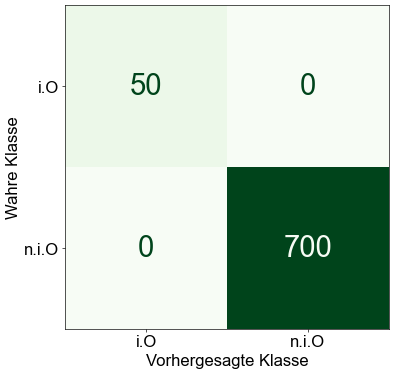

In [21]:
ch.plot_calc_cm(y_test0, y_pred0, class_name=["i.O", "n.i.O"], dpi=60)

In [77]:
search.best_params_

{'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=20),
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 20,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2}

In [41]:
def collect_results(clf, y_true, y_pred, algorithm, params, best_param):
    
    res = {"algorithm":algorithm, "params":params, "best_param":best_param,
           "rec_0":None, "pre_0":None, "f1_0":None, "rec_weighted":None, "pre_weighted":None, "f1_weighted":None, "acc":None}
    
    y_true0 = ch.swap_zero_one(y_true, 0)
    y_pred0 = ch.swap_zero_one(y_pred, 0)
    
    res["rec_0"] = recall_score(y_true0, y_pred0)
    res["pre_0"] = precision_score(y_true0, y_pred0)
    res["f1_0"] = f1_score(y_true0, y_pred0)
    res["rec_weighted"]= recall_score(y_true, y_pred, average='weighted')
    res["f1_weighted"]= f1_score(y_true, y_pred, average='weighted')
    res["pre_weighted"]= precision_score(y_true, y_pred, average='weighted')
    res["acc"] = accuracy_score(y_true, y_pred)
    
    for val in res.keys():
        if res[val]==None:
            print("somethong is wrong")
    
    return res

In [42]:
res = collect_results(best_clf, y_test, y_pred, algorithm="randomforest", params=parameters, best_param=search.best_params_)
res

{'algorithm': 'randomforest',
 'params': {'classifier__n_estimators': [50, 100, 200],
  'classifier__criterion': ['gini', 'entropy'],
  'classifier__min_samples_leaf': [1, 4, 8],
  'classifier__min_samples_split': [2, 4, 8],
  'classifier__max_depth': [20, 80, 200],
  'classifier__max_features': ['sqrt', 'log2'],
  'classifier__min_impurity_decrease': [0.0, 0.0001, 0.001]},
 'best_param': {'classifier__criterion': 'entropy',
  'classifier__max_depth': 80,
  'classifier__max_features': 'sqrt',
  'classifier__min_impurity_decrease': 0.001,
  'classifier__min_samples_leaf': 1,
  'classifier__min_samples_split': 4,
  'classifier__n_estimators': 100},
 'rec_0': 1.0,
 'pre_0': 1.0,
 'f1_0': 1.0,
 'rec_weighted': 0.8933333333333333,
 'pre_weighted': 0.9709925366741724,
 'f1_weighted': 0.9275737818376503,
 'acc': 0.8373333333333334}

In [43]:
filename = "mlc_ml_br_hyperopt_results_v2.4.json"
key_algorithm = "rf"
hyperopt_result = res

In [44]:
if os.path.exists(f"results/{filename}") == False:
    with open(f"results/{filename}", "w") as f:
        json.dump({f"{key_algorithm}":hyperopt_result}, f)
        f.close()
else:
    with open(f"results/{filename}", "r") as f:
        data = json.load(f)
        data.update({f"{key_algorithm}":hyperopt_result})
        
    with open(f"results/{filename}", "w") as f:
        json.dump(data, f)
        f.close()